JAX detected devices: [CudaDevice(id=0)]
Starting LEVER Driver for system: ../benchmark/FCIDUMP/N2_sto3g.FCIDUMP
  - Model: BackflowMLP
  - Evolution Strategy: BasicStrategy

--- Cycle 1/5 ---
Space sizes | S: 1, C: 131
NNZ counts  | H_SS: 1, H_SC: 131
  Step   50/500 | E = -106.37776765 Ha
  Step  100/500 | E = -106.37845324 Ha
  Step  150/500 | E = -106.37862272 Ha
  Step  200/500 | E = -106.37870614 Ha
  Step  250/500 | E = -106.37875343 Ha
  Step  300/500 | E = -106.37878260 Ha
  Step  350/500 | E = -106.37880180 Ha
  Step  400/500 | E = -106.37881503 Ha
  Step  450/500 | E = -106.37882442 Ha
  Step  500/500 | E = -106.37883132 Ha
Final optimization energy: -106.37883132 Ha
Evolving S-space for next cycle...
New S-space size: 132

--- Cycle 2/5 ---
Space sizes | S: 132, C: 1609
NNZ counts  | H_SS: 2,253, H_SC: 6,365
  Step   50/500 | E = -106.91881432 Ha
  Step  100/500 | E = -106.94369591 Ha
  Step  150/500 | E = -107.51503962 Ha
  Step  200/500 | E = -107.63065143 Ha
  Step  250/

/home/wsmxcz/LEVER/lever/analysis.py:226: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


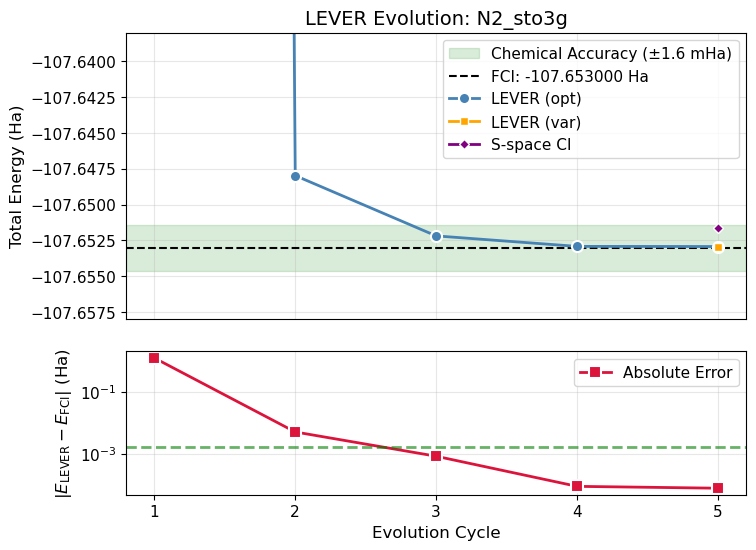

In [1]:
# examples/run_evolution.py

import lever
from lever import config, models, evolution, driver, analysis

import jax
import jax.numpy as jnp
print("JAX detected devices:", jax.devices())
jax.config.update("jax_platforms", "cuda")
jax.config.update("jax_log_compiles", False)

def main():
    # 1. Define Configuration
    sys_cfg = config.SystemConfig(
        fcidump_path="../benchmark/FCIDUMP/N2_sto3g.FCIDUMP",
        n_orbitals=10, n_alpha=7, n_beta=7
    )
    opt_cfg = config.OptimizationConfig(
        s_space_size=200, steps_per_cycle=500, num_cycles=5
    )
    eval_cfg = config.EvaluationConfig(
        var_energy_mode=config.EvalMode.FINAL,
        s_ci_energy_mode=config.EvalMode.FINAL
    )
    screen_cfg = config.ScreeningConfig(mode=config.ScreenMode.DYNAMIC, eps1=1e-6)
    
    # Use float64 for higher precision
    engine_cfg = lever.engine.EngineConfig(compute_dtype=jnp.float64)

    lever_config = config.LeverConfig(
        system=sys_cfg, optimization=opt_cfg, evaluation=eval_cfg,
        screening=screen_cfg, engine=engine_cfg
    )

    # 2. Initialize Components
    model = models.Backflow(
        n_orbitals=sys_cfg.n_orbitals, n_alpha=sys_cfg.n_alpha, n_beta=sys_cfg.n_beta,
        seed=opt_cfg.seed, n_dets=1, generalized=True, restricted=False,
        hidden_dims=(256,), param_dtype=jnp.complex64
    )
    
    evo_strategy = evolution.BasicStrategy(
        scorer=evolution.scores.AmplitudeScorer(),
        selector=evolution.selectors.TopKSelector(k=opt_cfg.s_space_size)
    )

    # 3. Create and Run the Driver
    lever_driver = driver.Driver(lever_config, model, evo_strategy)
    results = lever_driver.run()

    # 4. Perform Analysis
    analysis_suite = analysis.AnalysisSuite(results, lever_driver.int_ctx)
    analysis_suite.print_summary()
    analysis_suite.plot_convergence()

if __name__ == "__main__":
    main()